# MS026 Preprocess
Created: 01/29/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS026'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw/MS026_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3340031  =      0.000 ...  3261.749 secs...


In [7]:
mne_data

<RawEDF | MS026_SWB.edf, 276 x 3340032 (3261.7 s), ~6.87 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LCMsP1',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'C33',
 'C34',
 'RCMsP1',
 'RCMsP2',
 'RCMsP3',
 'RCMsP4',
 'RCMsP5',
 'RCMsP6',
 'RCMsP7',
 'RCMsP8',
 'RCMsP9',
 'RCMsP10',
 'RCMsP11',
 'RCMsP12',
 'RCMsP13',
 'RCMsP14',
 'RCMsP15',
 'RCMsP16',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'Rm

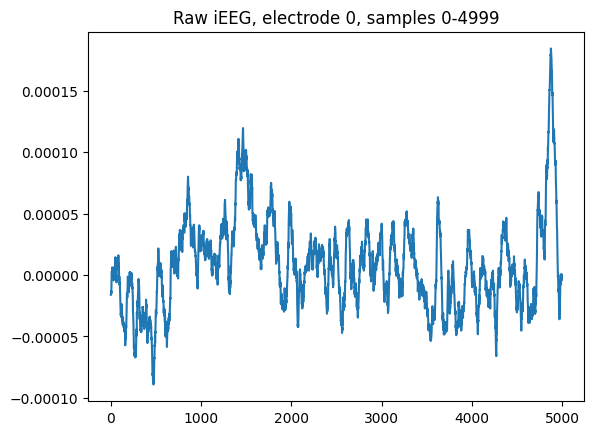

In [13]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [9]:
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   58.6s finished


<RawEDF | MS026_SWB.edf, 276 x 1630875 (3261.7 s), ~3.35 GB, data loaded>

### Photodiode
- examine photodiode 

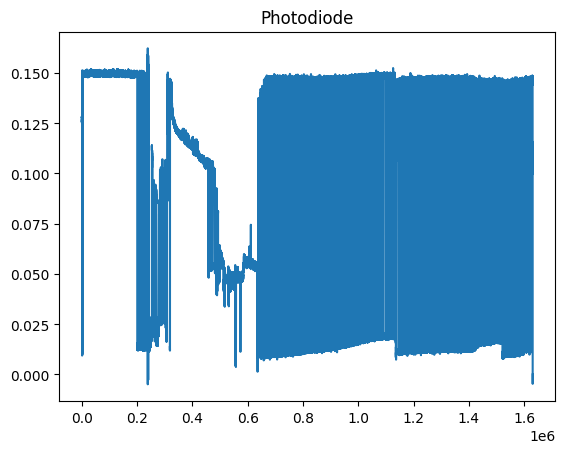

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [11]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/photodiode.fif
[done]


In [12]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

### Notch filter line noise

In [13]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:   13.9s finished


<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

### Anatomical Localization

In [14]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

In [15]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-2.954574,41.329210,4.799997,-3.150189,27.626674,-11.313929,Gray,Left ACgG anterior cingulate gyrus,Area s24,L Mid Orbital Gyrus,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9/46d_L,-14.150090,45.726392,48.399994,-14.612690,45.647438,30.886915,White,Left Cerebral White Matter,Unknown,L Superior Frontal Gyrus,L MFG,Unknown,WM,NaN
2,LaCaS11,A9l_L,-15.349610,46.126136,53.199994,-16.068791,47.523347,35.735259,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 D,WM,NaN
3,LaCaS12,A9l_L,-16.149290,46.126136,57.999994,-17.096981,48.985539,40.715012,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 D,OOB,NaN
4,LaCaS13,Unknown,-16.948969,46.126136,63.599993,-18.060868,50.562598,46.419275,Unknown,Unknown,Unknown,L Superior Frontal Gyrus,Unknown,Left superior frontal gyrus 2 D,OOB,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,RmOlF6,A11l_R,33.430855,50.123574,8.399997,36.273305,37.087206,-11.909190,Gray,Right LOrG lateral orbital gyrus,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis B,WM,NaN
164,RmOlF7,A12/47o_R,37.429254,49.723831,10.399996,40.477926,37.432671,-9.831393,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis B,NaN,NaN
165,RmOlF8,A12/47l_R,42.227333,49.723831,12.399996,45.600992,38.133258,-7.732312,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right anterior pars triangularis A,NaN,NaN
166,RmOlF9,A45r_R,46.625571,49.723831,14.799996,50.223671,38.960073,-5.163690,Gray,Right TrIFG triangular part of the inferior fr...,Unknown,R IFG (p Orbitalis),R IFG,Right anterior pars triangularis A,NaN,NaN


In [16]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMsP1',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'uLHplT',
 'LHtOc1',
 'LHtOc10',
 'LHtOc11',
 'LHtOc12',
 'LHtOc13',
 'LHtOc14',
 'LHtOc15',
 'LHtOc16',
 'LHtOc2',
 'LHtOc3',
 'LHtOc4',
 'LHtOc5',
 'LHtOc6',
 'LHtOc7',
 'LHtOc8',
 'LHtOc9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'uLmOlF',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13'

In [17]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c33', 'c34', 'rcmsp15', 'rcmsp16', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [18]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [19]:
unmatched_seeg #make sure there are no unmatched names


[]

In [20]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [21]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lcmsp1': 'lcmsp1',
 'lcmsp2': 'lcmsp2',
 'lcmsp3': 'lcmsp3',
 'lcmsp4': 'lcmsp4',
 'lcmsp5': 'lcmsp5',
 'lcmsp6': 'lcmsp6',
 'lcmsp7': 'lcmsp7',
 'lcmsp8': 'lcmsp8',
 'lcmsp9': 'lcmsp9',
 'lcmsp10': 'lcmsp10',
 'lcmsp11': 'lcmsp11',
 'lcmsp12': 'lcmsp12',
 'lcmsp13': 'lcmsp13',
 'lcmsp14': 'lcmsp14',
 'c33': 'c33',
 'c34': 'c34',
 'rcmsp1': 'rcmsp1',
 'rcmsp2': 'rcmsp2',
 'rcmsp3': 'rcmsp3',
 'rcmsp4': 'rcmsp4',
 'rcmsp5': 'rcmsp5',
 'rcmsp6': 'rcmsp6',
 'rcmsp7': 'rcmsp7',
 'rcmsp8': 'rcmsp8',
 'rcmsp9': 'rcmsp9',
 'rcmsp10': 'rcmsp10',
 'rcmsp11': 'rcmsp11',
 'rcmsp12': 'rcmsp12',
 'rcmsp13': 'rcmsp13',
 'rcmsp

In [22]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

In [23]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 82 left sEEG and 84 right sEEG electrodes
We have a total of 166 sEEG electrodes


In [24]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

In [25]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS026_SWB.edf, 166 x 1630875 (3261.7 s), ~2.02 GB, data loaded>

In [26]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS026_SWB.edf, 166 x 1630875 (3261.7 s), ~2.02 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [32]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [33]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [34]:
probe_ch_counts

{'lacas': 14,
 'laglt': 9,
 'lcmsp': 14,
 'lhplt': 10,
 'lhtoc': 16,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmsp': 14,
 'rhplt': 10,
 'rhtoc': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulhplt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [35]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) # good for this patient

['lhplt3', 'lmolf2', 'raglt2', 'rcmsp10', 'rhplt10', 'rmolf2']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


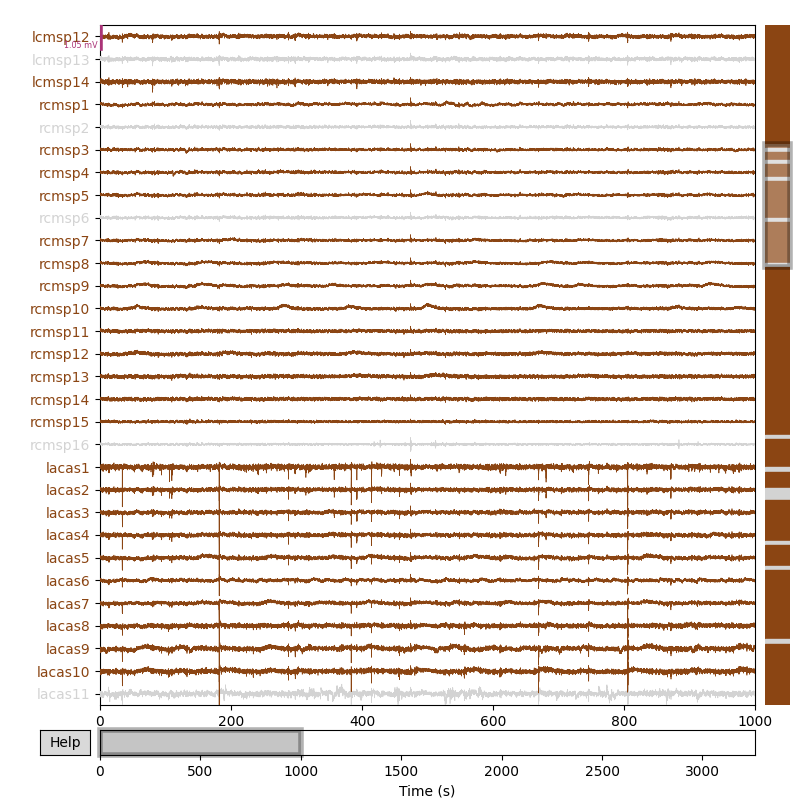

In [7]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/20)


In [27]:
mne_data.info['bads'] = ['lacas11',
 'laglt5',
 'rhplt9',
 'raglt9',
 'lhplt1',
 'lhplt2',
 'rcmsp16',
 'rhplt3',
 'raglt4',
 'rhtoc1',
 'rcmsp2',
 'lcmsp13',
 'rcmsp6']

In [28]:
mne_data.info['bads']

['lacas11',
 'laglt5',
 'rhplt9',
 'raglt9',
 'lhplt1',
 'lhplt2',
 'rcmsp16',
 'rhplt3',
 'raglt4',
 'rhtoc1',
 'rcmsp2',
 'lcmsp13',
 'rcmsp6']

In [29]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 13 items (lacas11, laglt5, rhplt9, raglt9, lhplt1, lhplt2, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 166 sEEG
 custom_ref_applied: False
 dig: 164 items (164 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 11:15:14 UTC
 nchan: 166
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [30]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [31]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=67, n_times=1630875
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, laglt1-laglt2, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, lcmsp1-lcmsp2, lcmsp2-lcmsp3, lcmsp3-lcmsp4, lcmsp4-lcmsp5, lcmsp5-lcmsp6, lcmsp6-lcmsp7, lcmsp7-lcmsp8, lcmsp11-lcmsp12, lcmsp12-lcmsp14, lhplt7-lhplt8, lhtoc10-lhtoc11, lhtoc11-lhtoc12, lhtoc13-lhtoc14, lhtoc14-lhtoc15, lmcms2-lmcms3, lmcms3-lmcms4, lmolf1-lmolf2, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmolf8-lmolf9, racas5-racas6, racas6-racas7, racas7-racas8, racas10-racas11, raglt1-raglt2, raglt2-raglt3, raglt3-raglt5, raglt6-raglt7, raglt7-raglt8, rcmsp1-rcmsp3, rcmsp3-rcmsp4, rcmsp9-rc

In [32]:
mne_data_bp_reref

<RawEDF | MS026_SWB.edf, 67 x 1630875 (3261.7 s), ~833.8 MB, data loaded>

In [33]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'laglt1-laglt2',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'lcmsp1-lcmsp2',
 'lcmsp2-lcmsp3',
 'lcmsp3-lcmsp4',
 'lcmsp4-lcmsp5',
 'lcmsp5-lcmsp6',
 'lcmsp6-lcmsp7',
 'lcmsp7-lcmsp8',
 'lcmsp11-lcmsp12',
 'lcmsp12-lcmsp14',
 'lhplt7-lhplt8',
 'lhtoc10-lhtoc11',
 'lhtoc11-lhtoc12',
 'lhtoc13-lhtoc14',
 'lhtoc14-lhtoc15',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmolf1-lmolf2',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'racas5-racas6',
 'racas6-racas7',
 'racas7-racas8',
 'racas10-racas11',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt3-raglt5',
 'raglt6-raglt7',
 'raglt7-raglt8',
 'rcmsp1-rcmsp3',
 'rcmsp3-rcmsp4',
 'rcmsp9-rcmsp10',
 'rcmsp10-rcmsp11',
 'rcmsp11-rcmsp12',
 'rcmsp12-rcmsp13',
 'rhplt1-rhplt2',
 'rhplt2-rhplt4',
 'rhplt4-rhplt5',
 'rhplt6-rhplt7',
 'rhplt7-rhplt8',
 'rhplt8-rhplt10',
 'rhto

#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


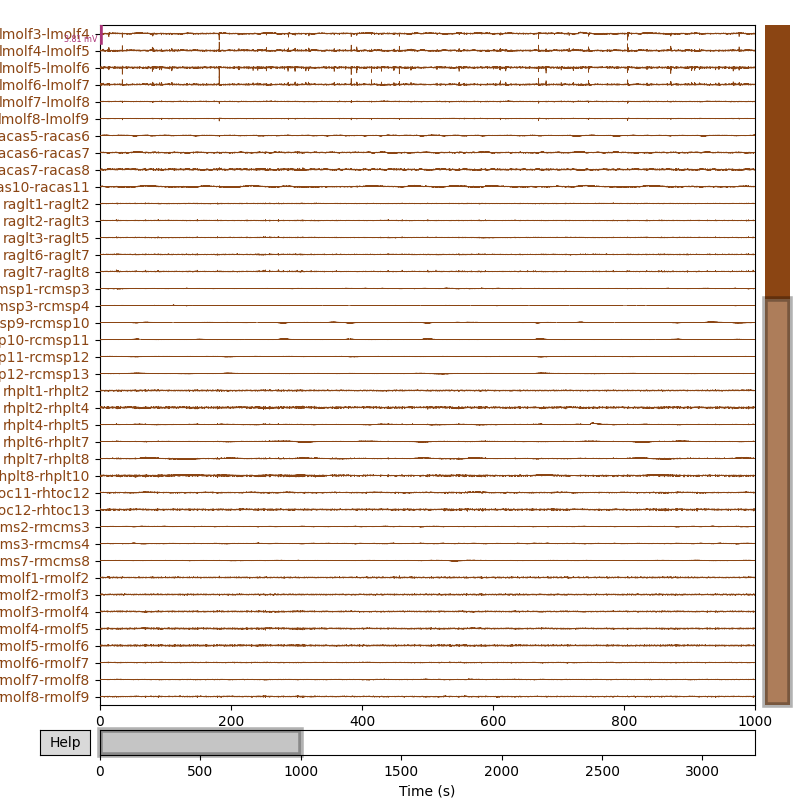

In [12]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


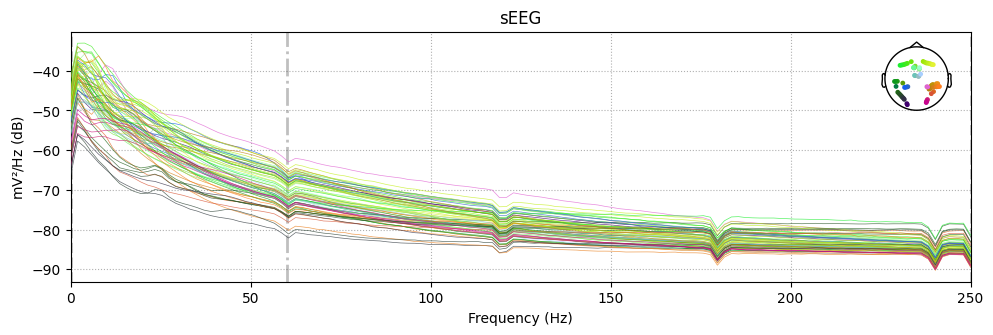

In [34]:
mne_data_bp_reref.compute_psd().plot()

In [35]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif
[done]


## Save mne_data

In [36]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [37]:
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', preload=True)

In [44]:
#remove mne_data from environment to save memory 
# del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [38]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/photodiode.fif...
Isotrak not found
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...


In [39]:
photodiode_data

<Raw | photodiode.fif, 1 x 1630875 (3261.7 s), ~12.4 MB, data loaded>

In [40]:
photodiode_data.info['sfreq']

500.0

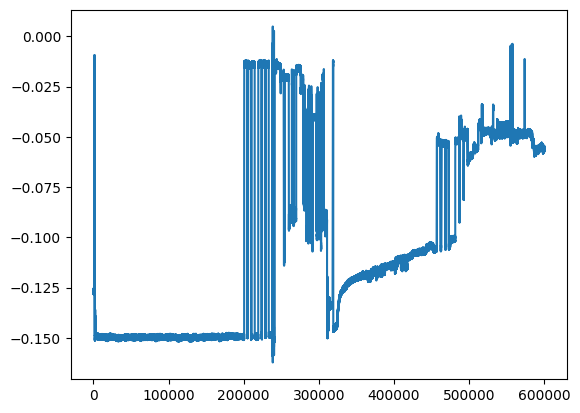

In [66]:
plt.plot(-photodiode_data._data[0, :600000])
# plt.plot(-photodiode_data._data[0, 1000000:1500000])
plt.show()

In [60]:
np.min(temp_diode._data)

-0.1622619777917862

In [67]:
##### FROM SALMAN

temp_diode = photodiode_data.copy() 
temp_diode._data = -temp_diode._data

temp_diode._data[0, 0:600000] = np.min(temp_diode._data)

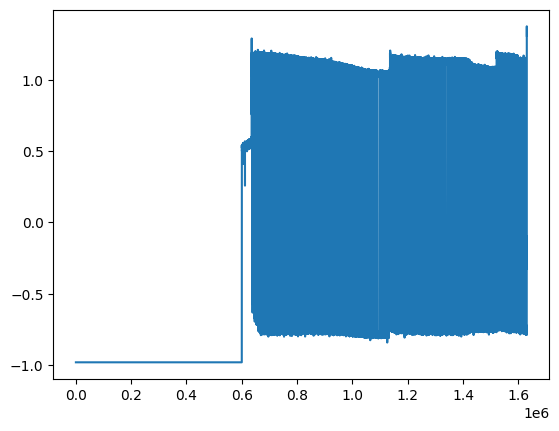

In [68]:
plt.plot(scipy.stats.zscore(temp_diode._data[0, :]))
plt.show()

In [80]:
### Photodiode alignment
smoothSize=11
windSize=15

height=0.85

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

9 blocks
.........

found matches for 105 of 147 pulses


In [98]:
print(slope,offset)

0.9999950671514789 1064.9503706422026


In [82]:

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [84]:
neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=15, height=1)
neural_ts.shape

(143,)

In [86]:
pulses = [(x*slope + offset) for x in beh_ts]

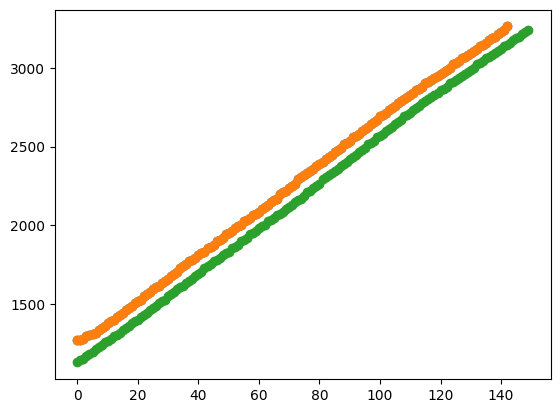

In [87]:
plt.plot(neural_ts,'o')
plt.plot(pulses,'o')
plt.show()

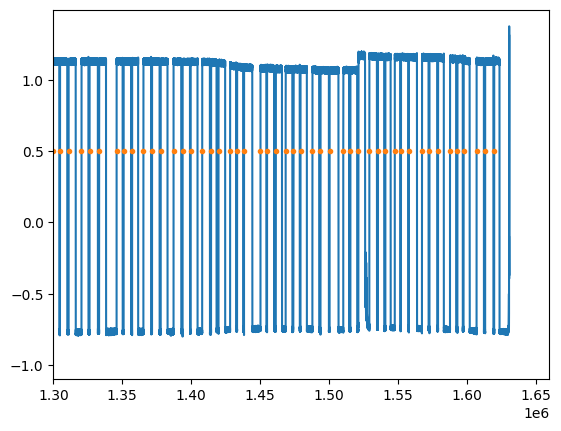

In [97]:


plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses)*500)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([1300000,1660000])
plt.show()

# temp_diode = photodiode_data.copy()
# temp_diode._data[0,0:1000000] = np.min(temp_diode._data[0,:])
# temp_diode._data[0,3000000:] = np.min(temp_diode._data[0,:])

(1300000.0, 1800000.0)

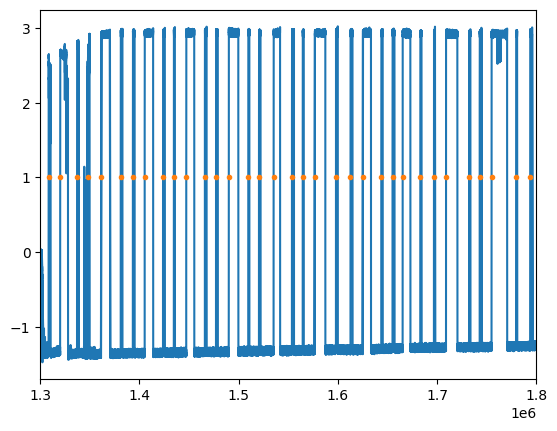

In [12]:
# plt.plot(scipy.stats.zscore(temp_diode._data[0, 0:1800000]))
# plt.plot(neural_ts[(neural_ts>1300000/1024) & (neural_ts<1800000/1024)]*1024, 
#          np.ones_like(neural_ts[(neural_ts>1300000/1024) & (neural_ts<1800000/1024)]), '.')
# plt.xlim([1300000,1800000])

Salman note 1: we can be confident that we are getting the onsets of these pulses

(array([25., 60., 16.,  5., 15., 18.,  5.,  2.,  2.,  1.]),
 array([ 8.6742898 , 10.70282113, 12.73135246, 14.75988379, 16.78841512,
        18.81694645, 20.84547778, 22.87400911, 24.90254044, 26.93107177,
        28.9596031 ]),
 <BarContainer object of 10 artists>)

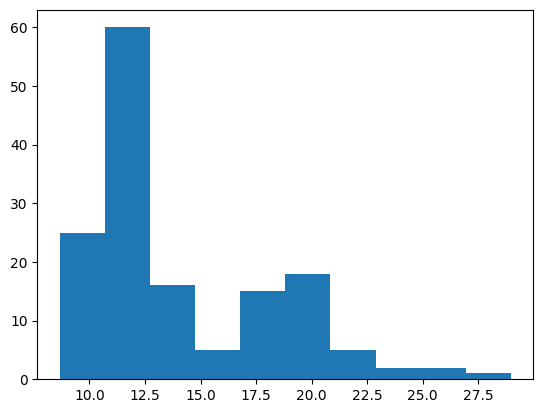

In [13]:
plt.hist(np.diff(beh_ts))

(array([24., 52., 17.,  9., 20.,  8.,  3.,  3.,  1.,  2.]),
 array([ 8.86132812, 10.85517578, 12.84902344, 14.84287109, 16.83671875,
        18.83056641, 20.82441406, 22.81826172, 24.81210937, 26.80595703,
        28.79980469]),
 <BarContainer object of 10 artists>)

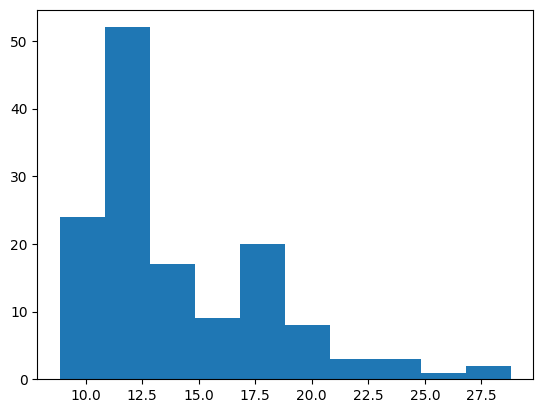

In [14]:
plt.hist(np.diff(neural_ts))

Salman note 2: We can be confident these pulses have similar inter-pulse interval profiles

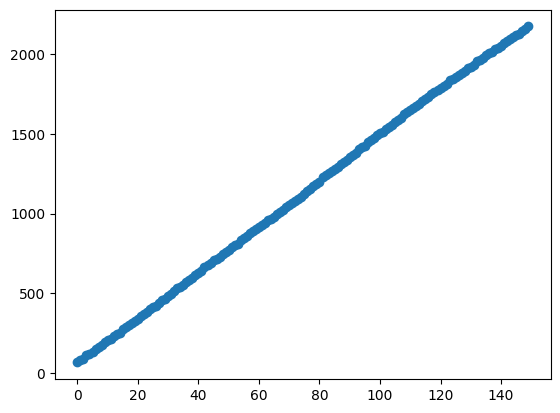

In [15]:
plt.plot(beh_ts,'o')

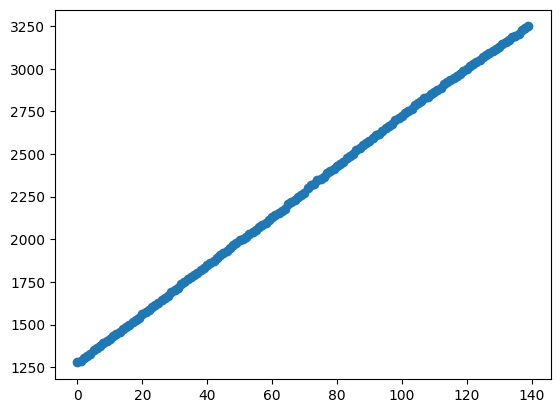

In [16]:
plt.plot(neural_ts,'o')

Salman note 3: We can see the pulses evolve the same way over time

So, let's just correlate the pulses themselves (not their interpulse intervals). 

However, the lengths mismatch. From the plot of the photodiode we know we probably missed them from the beginning of the recording (and maybe from the end? Though that's hard to tell). So, let's slide the behavioral timestamps by 1 until we find the behavioral timestamps that most strongly correlate with the detected neural timestamps. 

In [17]:
nwin = len(beh_ts) - len(neural_ts)
rvals = []
slopes = [] 
offsets = []
for i in range(nwin+1):
    slope, offset, rval = sync_utils.sync_matched_pulses(beh_ts[i:140+i].values, neural_ts)
    rvals.append(rval)
    slopes.append(slope)
    offsets.append(offset)
rvals = np.array(rvals)
offsets = np.array(offsets)
slopes = np.array(slopes)

In [18]:
np.argmax(rvals)

10

In [19]:
rvals[10]

0.9999971078602559

In [20]:
slopes[10]

0.9997645226435138

In [21]:
offsets[10]

1075.3648221231379

In [22]:
[(x*slopes[10] + offsets[10]) for x in beh_ts]

[1140.3380652919886,
 1154.1705366909332,
 1164.613897936648,
 1184.415644475427,
 1194.843547462147,
 1206.0076627465362,
 1226.2005629558587,
 1236.9589957917638,
 1248.3464966615916,
 1267.9351952802267,
 1278.605545762458,
 1290.1295530806206,
 1307.2371175876228,
 1317.366578467242,
 1328.510913210585,
 1348.54035841895,
 1360.8318786625491,
 1372.817994638808,
 1391.0245300022711,
 1402.517593008662,
 1412.4170832538593,
 1431.52632040129,
 1443.6592092078906,
 1454.6671334804419,
 1474.8603812078818,
 1485.7298198983094,
 1496.7324054282772,
 1515.9622878599032,
 1529.651560186979,
 1539.283905053615,
 1560.5097649669965,
 1572.7615641662417,
 1587.2535612252966,
 1605.4587436073712,
 1616.9633830871662,
 1628.5945216723867,
 1644.1798172236854,
 1655.2492865004247,
 1668.426798963735,
 1690.4440739728961,
 1703.2542339598353,
 1714.1168901477959,
 1739.4232751635786,
 1749.344402412501,
 1764.0500282550038,
 1781.8422758968088,
 1791.9185221100556,
 1803.3149594750053,
 1821.75

In [24]:
slope = slopes[10]
offset = offsets[10]
print(slope,offset)

0.9997645226435138 1075.3648221231379


In [ ]:
####### need to add save slope/offset 



In [81]:
# #### alie attempts 

# # temp_diode = photodiode_data.copy()
# # # temp_data = -temp_diode._data[0,:]
# # temp_data = temp_diode._data[0,:]
# # # temp_data = np.abs(temp_diode._data[0, :])
# # temp_data[0:1250000] = 0.06
# # temp_diode._data = temp_data

# temp_diode2 = photodiode_data.copy()

# # Specify the window size for the rolling mean
# window_size = 3

# # Calculate the rolling mean
# rolling_mean = pd.Series(temp_diode2._data[0,:]).rolling(window=window_size).mean()

# # Subtract the rolling mean from the original signal
# detrended_data = temp_diode2._data[0,:] - rolling_mean

# detrended_data.fillna(0, inplace=True)

# detrended_data = detrended_data.values

# # temp_data[temp_data>0.8] = -2
# # detrended_data[0:450000] = 0

# # detrended_data[570000:] = 0

# temp_diode2._data = detrended_data

#neural_ts = sync_utils.get_neural_ts_photodiode(temp_diode, smoothSize=11, height=1)

#plt.plot(photodiode_data._data[0, 1500000:1700000])
# plt.plot(detrended_data)
# # plt.plot(neural_ts * photodiode_data.info['sfreq'], 0.01 * np.ones_like(neural_ts * photodiode_data.info['sfreq']),'.')
# plt.show()

In [269]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [99]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [100]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [101]:
# quality control before epoching

print(slope,offset)


0.9999950671514789 1064.9503706422026


In [102]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [103]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
#                  behav_name=event, behav_times=behav_df[event].values, 
                 behav_name=event, behav_times=beh_ts,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) 

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif...
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    5.4s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 67 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif...
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    4.6s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 67 columns


In [104]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~115.2 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~268.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [105]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [106]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 89 columns
Replacing existing metadata with 89 columns


In [107]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas2-lacas3,lacas5-lacas6,lacas6-lacas7,lacas7-lacas8,lacas8-lacas9,laglt1-laglt2,laglt6-laglt7,laglt7-laglt8,laglt8-laglt9,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.50,1.50,0.00,0.00,1.50,1.50,-1.50,-1.50,0.00,0.000
1,NaN,NaN,NaN,NaN,NaN,NaN,"[1146.55, 1146.912, 1147.502]",NaN,[1146.898],NaN,...,-0.75,-0.75,-0.75,-0.75,0.00,0.00,0.75,0.75,0.00,0.000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.56,-0.20,-0.56,-0.20,0.00,0.00,0.56,0.20,0.00,-0.280
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.49,-0.60,-1.49,-0.60,0.00,0.00,1.49,0.60,0.00,-0.745
4,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.84,0.64,0.00,0.00,0.84,0.64,0.00,0.20,0.42,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,noise,...,1.08,0.30,0.00,0.00,1.08,0.30,-1.08,-0.30,0.54,0.000
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[3199.464],...,-0.36,-0.36,-0.36,-0.36,0.00,0.00,0.36,0.36,0.00,0.000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[3216.202],NaN,...,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.84,0.30,0.00,-0.420
148,noise,NaN,NaN,NaN,NaN,NaN,"[3230.758, 3231.176]",NaN,NaN,NaN,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.00,0.000


### Save raw epoched data 

In [108]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [109]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [110]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [111]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [112]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

# This function just pulls out dicts that tell you what epochs are good and bad for each channel
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]
    

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [113]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~1.13 GB>}

In [114]:
power_epochs = {}

In [115]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 89 columns


In [116]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 67, ~5.62 GB>

In [117]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [388]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)
# del epochs_all_baseline, power_epochs, plot_data

In [118]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04072024


In [119]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


1064.9503706422026
